<a href="https://colab.research.google.com/github/splevine/harnessing-nlp-cx-demo/blob/main/notebooks/Topic_Modeling_with_BERTopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling using BERTopic**
* Create easily interpretable topics with BERTopic and LLMs*
* [BERTopic](https://github.com/MaartenGr/BERTopic)
* [BERTopic Docs](https://maartengr.github.io/BERTopic)

* Example of creation of topics using BERTopic
* Visualizing topics using [DataMapPlot](https://datamapplot.readthedocs.io/en/latest/demo.html)
<br>

BERTopic was created and is maintained by the incredible Maarten Grootendorst. Thank you Maarten for creating an awesome library!

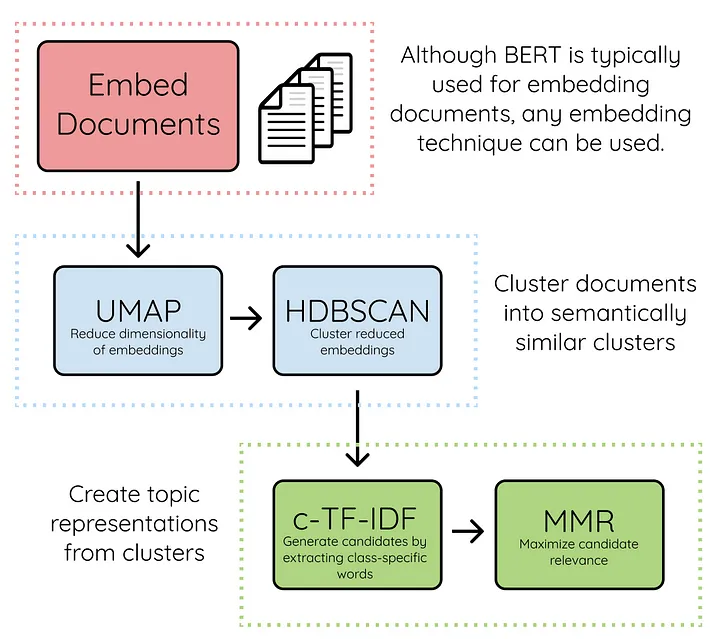


Topic modeling process
1. Convert the documents to numerical data. We use BERT for this purpose as it extracts different embeddings based on the context of the word
2. BERTopic by default performs the “c-TF IDF” (class-based TF-IDF) process after clustering the documents. Extracts the most used mutual words for every cluster.
3. It uses a “SentenceTransformer” as the embedding model.
4. It uses UMAP or Unification Map for every embedding to reduce the dimensionality.
5. It uses HDBSCAN for clustering with the “UMAP” embeddings.
6. Assign the “topic models” to the created variable after using “fit_transform” with the documents.
7. Representation layer of KeyBERT and OpenAI for generating topic names

💡 NOTE: We will want to use a GPU to run BERTopic. In Google Colab, go to Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4 (or any other GPU)

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


### Installs

In [ ]:
!pip install bertopic
!pip install openai
!pip install wandb

# DataMapPlot
!git clone https://github.com/TutteInstitute/datamapplot.git
!pip install datamapplot/.

fatal: destination path 'datamapplot' already exists and is not an empty directory.
Processing ./datamapplot
  Preparing metadata (setup.py) ... done
  Created wheel for datamapplot: filename=datamapplot-0.2.2-py3-none-any.whl size=34668 sha256=ee0b1f0e4ba9f3ede25daf783e95a0ad07b08bba892adc46e50f86e45be610a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-uomlvh6t/wheels/2c/f4/e9/508d3af0103e62b396709cf96ded29c6eafe14e3dda3b80c07
Successfully built datamapplot
  Attempting uninstall: datamapplot
    Found existing installation: datamapplot 0.2.2
    Uninstalling datamapplot-0.2.2:
      Successfully uninstalled datamapplot-0.2.2


## Imports

In [ ]:
import os
import openai
import pandas as pd
import numpy as np
import collections

from datetime import datetime

from sentence_transformers import SentenceTransformer

from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import OpenAI, KeyBERTInspired

from sentence_transformers import SentenceTransformer
from umap import UMAP

import wandb

import seaborn as sns
import matplotlib.pyplot as plt

import PIL
import datamapplot

## OpenAI Credentials
If you want to use OpenAI for your representation layer, add OPENAI_API_KEY to your environment. In Google Colab this can be done using [colab secrets](https://x.com/GoogleColab/status/1719798406195867814?s=20)

In [ ]:
from google.colab import userdata

# OpenAI
openai.api_key = userdata.get('OPENAI_API_KEY')
client = openai.OpenAI(api_key=openai.api_key)

# 📄 **Data**
Data is from [DSTC Track 2 from ACL 2023](https://github.com/amazon-science/dstc11-track2-intent-induction)

In [ ]:
# make sure to connect to Google Drive if you want to access csv from drive
%cd drive/MyDrive/DataHour/demo/

/content/drive/MyDrive/DataHour/demo


In [ ]:
!ls data

banking.csv	dialogues.jsonl       test_banking.csv	     train_banking.csv
banking.gsheet	prepared_banking.csv  test-utterances.jsonl


In [ ]:
df = pd.read_csv('data/train_banking.csv', index_col=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dialogue_id    1503 non-null   object
 1   turn_id        1503 non-null   object
 2   speaker_role   1503 non-null   object
 3   utterance      1503 non-null   object
 4   dialogue_acts  1503 non-null   object
 5   intents        1503 non-null   object
dtypes: object(6)
memory usage: 82.2+ KB


In [ ]:
df.head()

,dialogue_id,turn_id,speaker_role,utterance,dialogue_acts,intents
0,banking_0000,banking_0000_001,Customer,Yes I called earlier to see if you could see a...,['InformIntent'],CheckAccountBalance
1,banking_0000,banking_0000_039,Customer,Actually yes. Could you also give me the balan...,['InformIntent'],CheckAccountBalance
2,banking_0000,banking_0000_045,Customer,"OK, could you also tell me what the last depos...",['InformIntent'],CheckTransactionHistory
3,banking_0001,banking_0001_001,Customer,"yes, I need to change a email that I have on f...",['InformIntent'],UpdateEmail
4,banking_0002,banking_0002_001,Customer,yes. I've lost my phone last week on a trip to...,['InformIntent'],UpdatePhoneNumber


## Prepare Documents for Topic Modeling

In [ ]:
docs = df["utterance"].tolist()

# 🗨️ **BERTopic**

### Embeddings

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In this example I use [mxbai-embed-large-v1](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)

In [ ]:
# load embedding model
model_id = "mixedbread-ai/mxbai-embed-large-v1"
embedding_model = SentenceTransformer(model_id)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/112k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
# Pre-calculate embeddings
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
# Reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

### Define Sub-Modules

### UMAP

In [ ]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

#### HDBSCAN

In [ ]:
hdbscan_model = HDBSCAN(min_cluster_size=20,
                            min_samples=10,
                            metric='euclidean',
                            cluster_selection_method="leaf",
                            prediction_data=True,
                            )

## Representation Layer

#### Generate Names

In [ ]:
keybert = KeyBERTInspired()
openai_generator = OpenAI(client, model="gpt-3.5-turbo", chat=True, exponential_backoff=True)
representation_models = [keybert, openai_generator]

In [ ]:
representation_models

[KeyBERTInspired(),
 OpenAI(chat=True, client=<openai.OpenAI object at 0x7f5b7f41f820>,
        exponential_backoff=True, model='gpt-3.5-turbo',
        prompt='\n'
               'I have a topic that contains the following documents: \n'
               '[DOCUMENTS]\n'
               'The topic is described by the following keywords: [KEYWORDS]\n'
               '\n'
               'Based on the information above, extract a short topic label in '
               'the following format:\n'
               'topic: <topic label>\n')]

In [ ]:
topic_model = BERTopic(
  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_models,
  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [ ]:
# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-03-21 21:33:56,267 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-21 21:34:03,218 - BERTopic - Dimensionality - Completed ✓
2024-03-21 21:34:03,220 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-21 21:34:03,258 - BERTopic - Cluster - Completed ✓
2024-03-21 21:34:03,264 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 23/23 [00:15<00:00,  1.50it/s]
2024-03-21 21:34:19,842 - BERTopic - Representation - Completed ✓


In [ ]:
topic_model.save("models/banking_bertopic.safetensors",
                 serialization="safetensors",
                 save_ctfidf=True,
                 save_embedding_model=True)

Now that we are done training our model, let's see what topics were generated:

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,257,-1_Checking and Savings Account Assistance,[Checking and Savings Account Assistance],[OK great thank you so much. Now could since I...
1,0,163,0_Finding Nearby ATMs,[Finding Nearby ATMs],"[Yes, I need to find an ATM near where I am., ..."
2,1,110,1_Finding Nearby Bank Branches,[Finding Nearby Bank Branches],"[Yes, actually you can help me find a branch.,..."
3,2,109,2_banking account opening,[banking account opening],"[Yeah, I'd like to open up a bank account., ye..."
4,3,94,3_Wire Transfer Request,[Wire Transfer Request],"[Hi, I need to do a wire transfer., I have to ..."
5,4,93,4_Money Transfer Between Savings and Checking ...,[Money Transfer Between Savings and Checking A...,[And transfer the money from that to my checki...
6,5,76,5_Closing Savings Account,[Closing Savings Account],[Yes. I'm gonna need to close my savings accou...
7,6,70,6_Hours of Branch Operations,[Hours of Branch Operations],"[so, what about the branch hours are they open..."
8,7,53,7_Address Update Requests,[Address Update Requests],[OK. I'm My new address is seven. And. And if ...
9,8,53,8_Check Account Balance,[Check Account Balance],[I I I need to check the balance on my account...


## Assign Cluster to Messages

In [ ]:
df['cluster'] = topics

In [ ]:
df['cluster_score'] = probs

# 📊 Visualization with DataMapPlot

In [ ]:
!ls

data  Loris_Logo.png  Loris_Logo.svg  models  notebooks


In [ ]:
loris_logo = np.asarray(PIL.Image.open("Loris_Logo.png"))

### Create topic mapping
We can use the labels created by the LLM and assign them to topics that we have created:

In [ ]:
freq_df = topic_model.get_topic_info()

In [ ]:
freq_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,257,-1_Checking and Savings Account Assistance,[Checking and Savings Account Assistance],[OK great thank you so much. Now could since I...
1,0,163,0_Finding Nearby ATMs,[Finding Nearby ATMs],"[Yes, I need to find an ATM near where I am., ..."
2,1,110,1_Finding Nearby Bank Branches,[Finding Nearby Bank Branches],"[Yes, actually you can help me find a branch.,..."
3,2,109,2_banking account opening,[banking account opening],"[Yeah, I'd like to open up a bank account., ye..."
4,3,94,3_Wire Transfer Request,[Wire Transfer Request],"[Hi, I need to do a wire transfer., I have to ..."
5,4,93,4_Money Transfer Between Savings and Checking ...,[Money Transfer Between Savings and Checking A...,[And transfer the money from that to my checki...
6,5,76,5_Closing Savings Account,[Closing Savings Account],[Yes. I'm gonna need to close my savings accou...
7,6,70,6_Hours of Branch Operations,[Hours of Branch Operations],"[so, what about the branch hours are they open..."
8,7,53,7_Address Update Requests,[Address Update Requests],[OK. I'm My new address is seven. And. And if ...
9,8,53,8_Check Account Balance,[Check Account Balance],[I I I need to check the balance on my account...


In [ ]:
# create a cluster id to label name dictionary using freq_df Topic and Representation
topic_map = dict(zip(freq_df.Topic, freq_df.Representation))
# for all values in topic_map replace the value with the first element in list
topic_map = {key: topic_map[key][0] for key in topic_map.keys()}

In [ ]:
topic_map

{-1: 'Checking and Savings Account Assistance',
 0: 'Finding Nearby ATMs',
 1: 'Finding Nearby Bank Branches',
 2: 'banking account opening',
 3: 'Wire Transfer Request',
 4: 'Money Transfer Between Savings and Checking Accounts',
 5: 'Closing Savings Account',
 6: 'Hours of Branch Operations',
 7: 'Address Update Requests',
 8: 'Check Account Balance',
 9: 'Checking savings account balance.',
 10: 'phone number update for account',
 11: 'Disputing Transactions',
 12: 'Disputing unrecognized charges on a statement',
 13: 'Timing and Fees for Transfers',
 14: 'issue with account notice received via mail',
 15: 'Update Email Address for Account',
 16: 'checking account balance query',
 17: 'Reports of Missing and Stolen Debit and Credit Cards',
 18: 'Checking Account Balance Inquiry via Phone',
 19: 'checking account balance verification',
 20: 'Reporting Lost or Stolen Credit Card',
 21: 'Report Stolen Credit Card'}

In [ ]:
# replace value for -1 to be "Unlabelled"
topic_map[-1] = "Unlabelled"

In [ ]:
# use topic_map to create label for each doc in df
df["Topic"] = df["cluster"].map(topic_map)

In [ ]:
# convert df["Topic"] to an array
all_labels = df["Topic"].to_numpy()

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `KeyBERTInspired + OpenAI GPT-3.5`'}>)

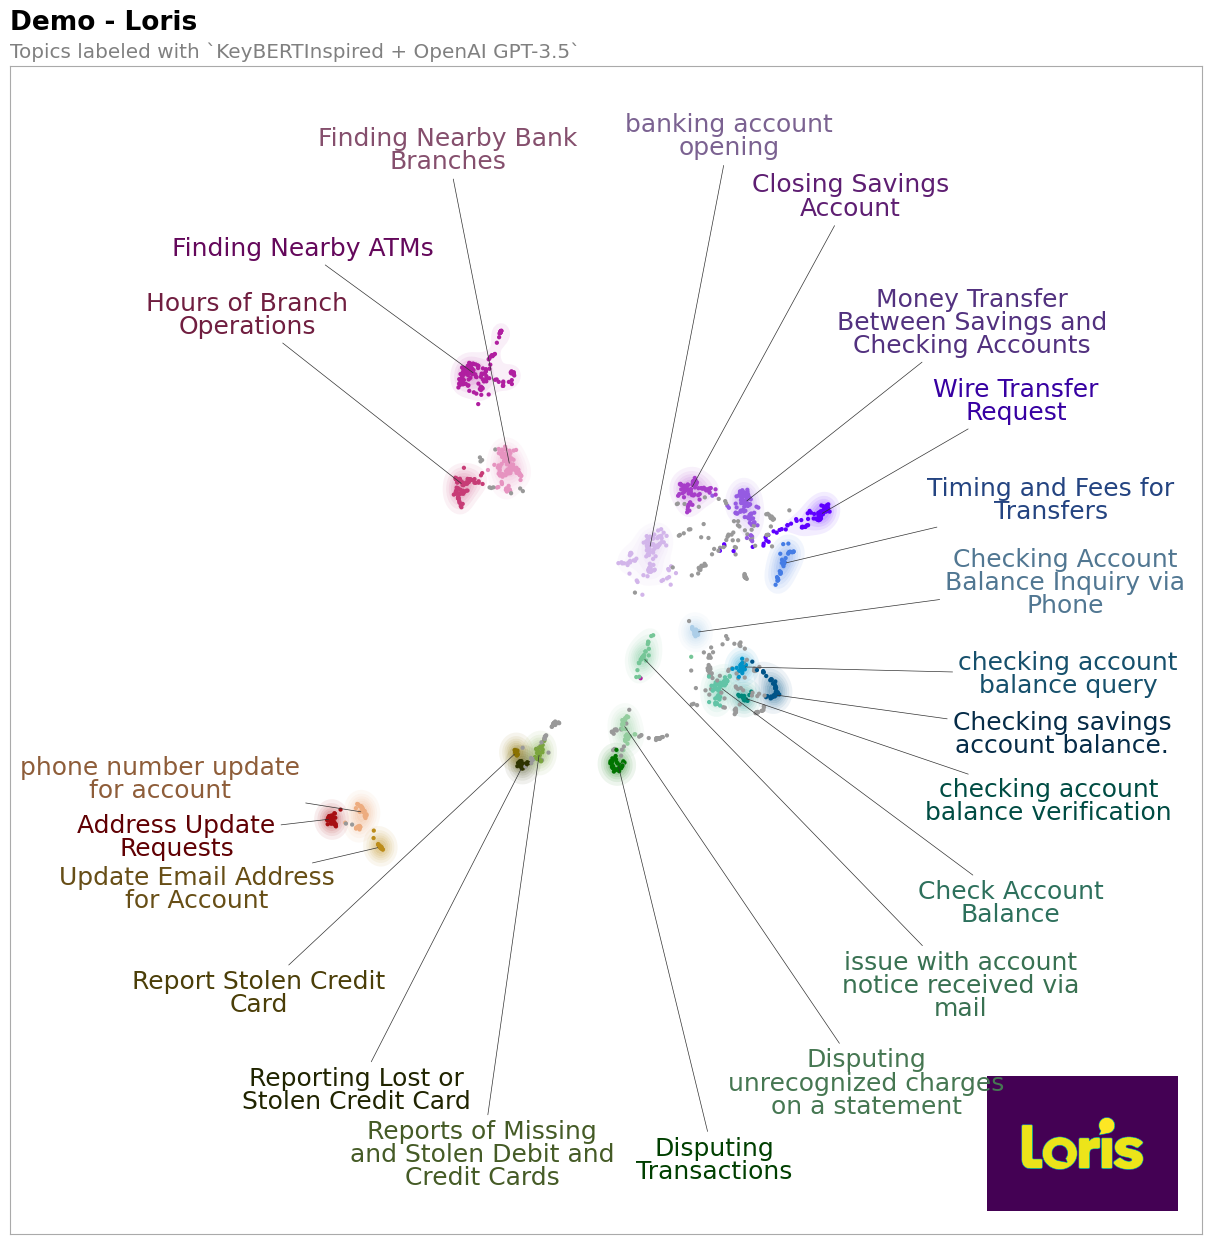

In [ ]:
# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=18,
    title="Demo - Loris",
    sub_title="Topics labeled with `KeyBERTInspired + OpenAI GPT-3.5`",
    label_wrap_width=20,
    use_medoids=True,
    logo=loris_logo,
    logo_width=0.16
)

## BERTopic Visualizations

### Visualize Topics

In [ ]:
topic_model.visualize_topics()

### Visualize Documents

In [ ]:
topic_model.visualize_documents(docs)

### Visualize Hierarchy

In [ ]:
topic_model.visualize_hierarchy()

### Visualize Similarity

In [ ]:
topic_model.visualize_heatmap()

### Visualize topics per class

In [ ]:
classes = df['intents'].tolist()

In [ ]:
topics_per_class = topic_model.topics_per_class(docs, classes=classes)

0it [00:00, ?it/s]
100%|██████████| 7/7 [00:04<00:00,  1.49it/s]
1it [00:05,  5.27s/it]
100%|██████████| 4/4 [00:02<00:00,  1.42it/s]
2it [00:08,  4.01s/it]
100%|██████████| 7/7 [00:03<00:00,  1.83it/s]
3it [00:12,  4.13s/it]
100%|██████████| 2/2 [00:02<00:00,  1.40s/it]
4it [00:15,  3.69s/it]
100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
5it [00:19,  3.69s/it]
100%|██████████| 6/6 [00:03<00:00,  1.73it/s]
6it [00:24,  4.02s/it]
100%|██████████| 6/6 [00:04<00:00,  1.47it/s]
7it [00:28,  4.17s/it]
100%|██████████| 3/3 [00:01<00:00,  1.69it/s]
8it [00:30,  3.48s/it]
100%|██████████| 4/4 [00:02<00:00,  1.61it/s]
9it [00:33,  3.35s/it]
100%|██████████| 2/2 [00:00<00:00,  2.09it/s]
10it [00:35,  2.81s/it]
100%|██████████| 2/2 [00:01<00:00,  1.70it/s]
11it [00:36,  2.50s/it]
100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
12it [00:38,  2.09s/it]
100%|██████████| 7/7 [00:04<00:00,  1.47it/s]
13it [00:43,  3.18s/it]
100%|██████████| 3/3 [00:01<00:00,  2.25it/s]
14it [00:45,  2.69s/it]
100%|█████

In [ ]:
topic_model.visualize_topics_per_class(topics_per_class)

### Other Visualizations
* Visualize Terms
* Visualize Term Score Decline
* Visualize Topics over Time
* Visualize Topic Document Distribution

## Move to Classifier :)